Language modeling (next char prediction) with multi-char context.

In [1]:
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures

%matplotlib inline

In [2]:
# same as part 1

# load raw data: 32_033 names, length in [2, 15]
words = open("names.txt", "r").read().splitlines()

# build char vocabulary and tokenizer
chars = sorted(set("".join(words)))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
print(f"encoder stoi={stoi}\ndecoder itos={itos}")

encoder stoi={'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
decoder itos={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


# Prep the Dataset

In [3]:
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size  # encoded sequence "..."
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # training
Xdev, Ydev = build_dataset(words[n1:n2])  # dev/validation
Xte, Yte = build_dataset(words[n2:])  # test

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Train the Model

In [4]:
def train(
    Xtr,
    C,
    W1,
    b1,
    W2,
    b2,
    n_iter,
    n_minibatch=32,
    lre=None,
    lrs=None,
    lri=None,
    lossi=None,
    stepi=None,
):
    parameters = [C, W1, b1, W2, b2]
    # print(sum(p.nelement() for p in parameters))  # 11_897 total parameters
    for p in parameters:
        p.requires_grad = True

    for i in range(n_iter):
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (n_minibatch,))  # samples of Xtr indices

        # forward pass
        emb = C[Xtr[ix]]  # (n_minibatch, block_size, embedding_dim)
        h = torch.tanh(
            emb.view(-1, emb.shape[1] * emb.shape[2]) @ W1 + b1
        )  # (n_minibatch, hidden_dim)
        logits = h @ W2 + b2  # (32, 27)
        loss = F.cross_entropy(logits, Ytr[ix])

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        if lrs is not None:
            lr = lrs[i]
        else:
            lr = 0.1 if i < 100_000 else 0.01
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        if lri is not None:
            lri.append(lre[i])
        if stepi is not None:
            stepi.append(i)
        if lossi is not None:
            lossi.append(loss.log10().item())

## Experiment with Initial Learning Rate

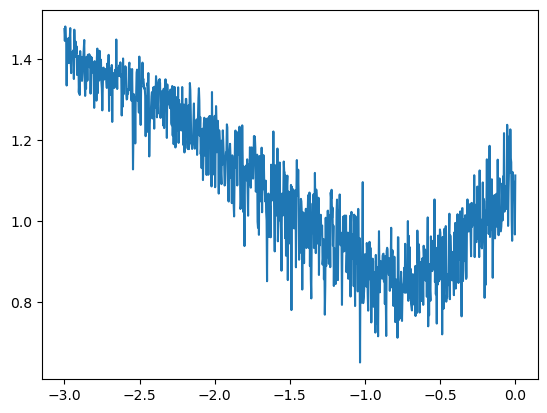

In [5]:
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
lre = torch.linspace(-3, 0, 1000)  # linear lr exponent search space
lrs = 10**lre  # exponential lr search space
lri = []
lossi = []
train(
    Xtr,
    C=torch.randn((27, 10), generator=g),
    W1=torch.randn((30, 200), generator=g),
    b1=torch.randn(200, generator=g),
    W2=torch.randn((200, 27), generator=g),
    b2=torch.randn(27, generator=g),
    n_iter=1000,
    n_minibatch=32,
    lre=lre,
    lrs=lrs,
    lri=lri,
    lossi=lossi,
)
plt.plot(lri, lossi)
# lr of 0.1 (lre of -1) a good starting point

## Visualize Simple 2D Embedding Matrix

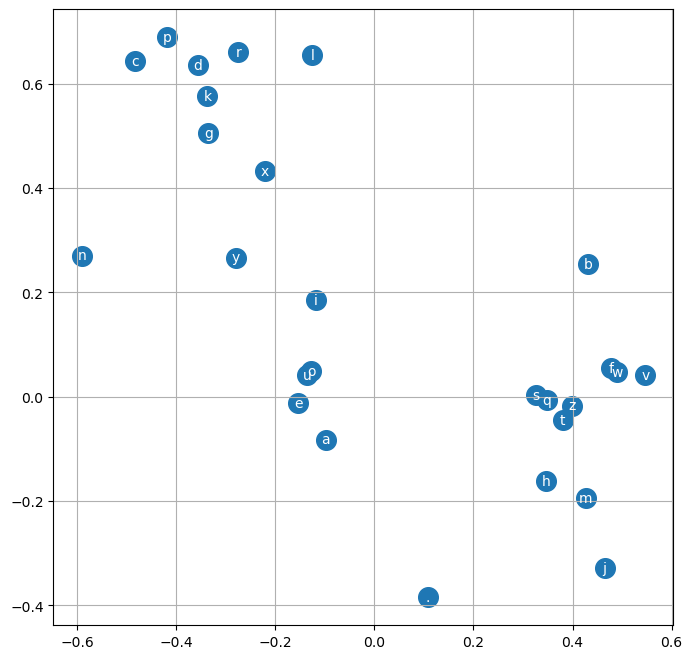

In [6]:
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((27, 2), generator=g)
lossi = []
train(
    Xtr,
    C,
    W1=torch.randn((6, 200), generator=g),
    b1=torch.randn(200, generator=g),
    W2=torch.randn((200, 27), generator=g),
    b2=torch.randn(27, generator=g),
    n_iter=10_000,
    n_minibatch=32,
    lossi=lossi,
)

plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(
        C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white"
    )
plt.grid("minor")

## Play with Hyperparameters

training_loss=tensor(2.1216, grad_fn=<NllLossBackward0>)
dev_loss=tensor(2.1617, grad_fn=<NllLossBackward0>)


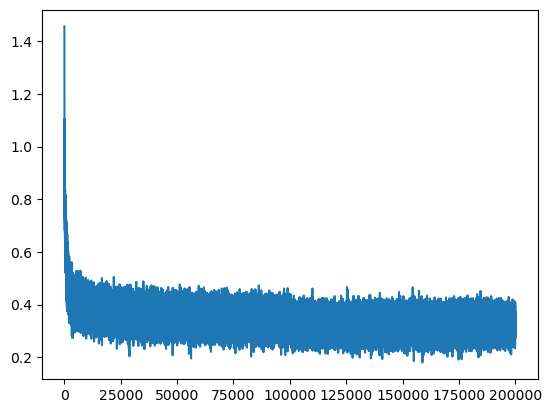

In [7]:
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn(
    (27, 10), generator=g
)  # -> input layer size (30) = block size (3) * embedding size (10)
W1 = torch.randn((30, 200), generator=g)  # hidden layer size: 200
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)  # output layer size = vocab
b2 = torch.randn(27, generator=g)

lossi = []
stepi = []
train(
    Xtr,
    C,
    W1,
    b1,
    W2,
    b2,
    n_iter=200_000,
    n_minibatch=64,
    lossi=lossi,
    stepi=stepi,
)
plt.plot(stepi, lossi)

emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
training_loss = F.cross_entropy(logits, Ytr)

emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
dev_loss = F.cross_entropy(logits, Ydev)

print(f"{training_loss=}\n{dev_loss=}")  # 2.1256
# underfit (training loss ~ dev loss) -> bigger model (bigger hidden layer, bigger embedding), optimize (more iter, lr)
# too much noise -> increase batch size

# Sample from the Model

In [8]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

mora.
mayan.
seel.
nihayla.
remman.
endrari.
azeerdieliigh.
poren.
eden.
van.
aar.
katzios.
kalin.
shorergsafwinst.
jaireth.
konnie.
cas.
brence.
ryyah.
faeha.
